### Problem 1

(100 points) Consider the following problem. 

$$
\begin{eqnarray*}
\hbox{min } f&=& x_1^2+(x_2-3)^2\\
\hbox{s.t. } g_1&=& x_2^2-2x_1\leq 0\\
             g_2&=& (x_2-1)^2+5x_1-15\leq 0\\
\end{eqnarray*}
$$

Implement an SQP algorithm with line search to solve this problem, starting from
${\bf x}_0=(1,1)^T$. Incorporate the QP subproblem. Use BFGS
approximation for the Hessian of the Lagrangian. Use the
merit function and Armijo Line Search to find the step size.

%%%%%%%%%%%%%% Main Entrance %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%% By Max Yi Ren and Emrah Bayrak %%%%%%%%%%%%%%%%%%%%%%%%%%%%%

% Instruction: Please read through the code and fill in blanks 
% (marked by ***). Note that you need to do so for every involved
% function, i.e., m files. 

%% Optional overhead
clear; % Clear the workspace
close all; % Close all windows

%% Optimization settings
% Here we specify the objective function by giving the function handle to a
% variable, for example:
f = @(x) x(1)^2+(x(2)-3)^2 ; % replace with your objective function
% In the same way, we also provide the gradient of the 
% objective:
df = @(x) [2*x(1), 2*x(2)-6]; % replace accordingly

g = @(x)[x(2)^2-2*x(1); (x(2)-1)^2+5*x(1)-15];
dg = @(x)[-2,2*x(2); 5, 2*x(2)-2];

% Note that explicit gradient and Hessian information is only optional.
% However, providing these information to the search algorithm will save
% computational cost from finite difference calculations for them.

% % Specify algorithm
opt.alg = 'myqp'; % 'myqp' or 'matlabqp'

% Turn on or off line search. You could turn on line search once other
% parts of the program are debugged.
opt.linesearch = true; % false or true

% Set the tolerance to be used as a termination criterion:
opt.eps = 1e-3;

% Set the initial guess:
x0 = [1;1];

% Feasibility check for the initial point.
if max(g(x0)>0)
    errordlg('Infeasible intial point! You need to start from a feasible one!');
    return
end
%% Run optimization
% Run your implementation of SQP algorithm. See mysqp.m
solution = mysqp(f, df, g, dg, x0, opt);
%% visualization
xx = linspace(0,3);
yy = linspace(0,3);
[xxx,yyy] = meshgrid(xx,yy);
fxx=xxx.^2+(yyy-3).^2;
g1=yyy.^2-2.*xxx<=0;
g2 = (yyy-1).^2+5.*xxx-15<=0;
sx1 = num2str(solution.x(1,length(solution.x)));
sx2 =  num2str(solution.x(2,length(solution.x)));
hold on
contour(xx,yy,g2)
contour(xx,yy,g1)
contour(xx,yy,fxx)
plot(solution.x(1,:),solution.x(2,:));
title(['Sequence of Solutions with Constraints Visualized Optimum = (' sx1,',', sx2,')'])
xlabel('x_1')
ylabel('x_2')
hold off
figure
hold on
plot(solution.x(1,:),solution.x(2,:));
contour(xx,yy,fxx)
title(['Sequence of Solutions w/o Constraints Visualized Optimum = (' sx1,',', sx2,')'])
xlabel('x_1')
ylabel('x_2')
hold off
X = solution.x(1,:);
Y = solution.x(2,:);

fx = zeros(1,length(X));
for e=1:length(X)
    fx(e) = X(e)^2+(Y(e)-3)^2;
end
figure
plot(fx)
title('optimum solution of f(x) per iteration')
xlabel('Iteration')
ylabel('F(x)')
%% Report
%report(solution,f,g);

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

 

%%%%%%%%%%%%%% Sequential Quadratic Programming Implementation with BFGS %%%%%%%%%%%%%%%%
%%%%%%%%%%%%%% By Max Yi Ren and Emrah Bayrak %%%%%%%%%%%%%%%%%%%%%%%%%%%%%

function solution = mysqp(f, df, g, dg, x0, opt)
    % Set initial conditions
    
    x = x0; % Set current solution to the initial guess
    
    % Initialize a structure to record search process
    solution = struct('x',[]); 
    solution.x = [solution.x, x]; % save current solution to solution.x
    
    % Initialization of the Hessian matrix
    W = eye(numel(x));             % Start with an identity Hessian matrix
    % Initialization of the Lagrange multipliers
    mu_old = zeros(size(g(x)));    % Start with zero Lagrange multiplier estimates
    % Initialization of the weights in merit function
    w = zeros(size(g(x)));         % Start with zero weights
    
    % Set the termination criterion
    gnorm = norm(df(x) + mu_old'*dg(x)); % norm of Largangian gradient

    while gnorm>opt.eps % if not terminated
        
        % Implement QP problem and solve
        if strcmp(opt.alg, 'myqp')
            % Solve the QP subproblem to find s and mu (using your own method)
            [s, mu_new] = solveqp(x, W, df, g, dg);
        else
            % Solve the QP subproblem to find s and mu (using MATLAB's solver)
            qpalg = optimset('Algorithm', 'interior-point-convex', 'Display', 'off');
            [s,~,~,~,lambda] = quadprog(W,[df(x)]',dg(x),-g(x),[], [], [], [], [],  qpalg);
            mu_new = lambda.ineqlin;
        end
        
        % opt.linesearch switches line search on or off. 
        % You can first set the variable "a" to different constant values and see how it
        % affects the convergence.
        if opt.linesearch
            [a, w] = lineSearch(f, df, g, dg, x, s, mu_old, w);
        else
            a = 0.1;
        end
        
        % Update the current solution using the step
        dx = a*s;               % Step for x
        x = x + dx;             % Update x using the step
        
        % Update Hessian using BFGS. Use equations (7.36), (7.73) and (7.74)
        % Compute y_k
        y_k = [df(x) + mu_new'*dg(x) - df(x-dx) - mu_new'*dg(x-dx)]'; 
        % Compute theta
        if dx'*y_k >= 0.2*dx'*W*dx
            theta = 1;
        else
            theta = (0.8*dx'*W*dx)/(dx'*W*dx-dx'*y_k);
        end
        % Compute  dg_k
        dg_k = theta*y_k + (1-theta)*W*dx;
        % Compute new Hessian
        W = W + (dg_k*dg_k')/(dg_k'*dx) - ((W*dx)*(W*dx)')/(dx'*W*dx);
        
        % Update termination criterion:
        gnorm = norm(df(x) + mu_new'*dg(x)); % norm of Largangian gradient
        mu_old = mu_new;

        % save current solution to solution.x
        solution.x = [solution.x, x]; 
    end

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

 

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

%The following code performs line search on the merit function

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

% Armijo line search
function [a, w] = lineSearch(f, df, g, dg, x, s, mu_old, w_old)
    t = 0.1; % scale factor on current gradient: [0.01, 0.3]
    b = 0.8; % scale factor on backtracking: [0.1, 0.8]
    a = 1; % maximum step length
    
    D = s;                  % direction for x
    
    % Calculate weights in the merit function using eaution (7.77)
    w = max(abs(mu_old), 0.5*(w_old+abs(mu_old)));
    % terminate if line search takes too long
    count = 0;
    while count<100
        % Calculate phi(alpha) using merit function in (7.76)
        phi_a = f(x + a*D) + w'*abs(min(0, -g(x+a*D)));
        
        % Caluclate psi(alpha) in the line search using phi(alpha)
        phi0 = f(x) + w'*abs(min(0, -g(x)));        % phi(0)
        dphi0 = df(x)*D + w'*((dg(x)*D).*(g(x)>0)); % phi'(0)
        psi_a = phi0 +  t*a*dphi0;                  % psi(alpha)
        % stop if condition satisfied
        if phi_a<psi_a
            break;
        else
            % backtracking
            a = a*b
            count = count + 1
        end
    end
end

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

 

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

%The following code solves the QP subproblem using active set strategy

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

function [s, mu0] = solveqp(x, W, df, g, dg)
    % Implement an Active-Set strategy to solve the QP problem given by
    % min     (1/2)*s'*W*s + c'*s
    % s.t.    A*s-b <= 0
    % 
    % where As-b is the linearized active contraint set
    
    % Strategy should be as follows:
    % 1-) Start with empty working-set
    % 2-) Solve the problem using the working-set
    % 3-) Check the constraints and Lagrange multipliers
    % 4-) If all constraints are staisfied and Lagrange multipliers are positive, terminate!
    % 5-) If some Lagrange multipliers are negative or zero, find the most negative one 
    %     and remove it from the active set
    % 6-) If some constraints are violated, add the most violated one to the working set
    % 7-) Go to step 2
    
    
    % Compute c in the QP problem formulation
    c = [df(x)]';     
    
    % Compute A in the QP problem formulation
    A0 = dg(x);           
    
    % Compute b in the QP problem formulation
    b0 = -g(x);           
    
    % Initialize variables for active-set strategy
    stop = 0;           % Start with stop = 0
    % Start with empty working-set
    A = [];         % A for empty working-set
    b = [];         % b for empty working-set
    % Indices of the constraints in the working-set
    active = [];    % Indices for empty-working set
    
    while ~stop  % Continue until stop = 1
        % Initialize all mu as zero and update the mu in the working set
        mu0 = zeros(size(g(x)));
        
        % Extact A corresponding to the working-set
        A = A0(active,:);
        % Extract b corresponding to the working-set
        b = b0(active);
        
        % Solve the QP problem given A and b
        [s, mu] = solve_activeset(x, W, c, A, b);
        % Round mu to prevent numerical errors (Keep this)
        mu = round(mu*1e12)/1e12;
        
        % Update mu values for the working-set using the solved mu values
        mu0(active) = mu;
        
        % Calculate the constraint values using the solved s values
        gcheck = A0*s-b0;
        
        % Round constraint values to prevent numerical errors (Keep this)
        gcheck = round(gcheck*1e12)/1e12;
        
        % Variable to check if all mu values make sense. 
        mucheck = 0;        % Initially set to 0
        
        % Indices of the constraints to be added to the working set
        Iadd = [];              % Initialize as empty vector
        % Indices of the constraints to be added to the working set
        Iremove = [];           % Initialize as empty vector 
        
        % Check mu values and set mucheck to 1 when they make sense
        if (numel(mu) == 0)
            % When there no mu values in the set
            mucheck = 1;         % OK
        elseif min(mu) > 0
            % When all mu values in the set positive
            mucheck = 1;         % OK
        else
            % When some of the mu are negative
            % Find the most negaitve mu and remove it from acitve set
            [~,Iremove] = min(mu);  % Use Iremove to remove the constraint 
        end
        
        % Check if constraints are satisfied
        if max(gcheck) <= 0
            % If all constraints are satisfied
            if mucheck == 1
                % If all mu values are OK, terminate by setting stop = 1
                stop = 1;
            end
        else
            % If some constraints are violated 
            % Find the most violated one and add it to the working set
            [~,Iadd] = max(gcheck); % Use Iadd to add the constraint
        end
        % Remove the index Iremove from the working-set
        active = setdiff(active, active(Iremove));
        % Add the index Iadd to the working-set
        active = [active, Iadd];
        
        % Make sure there are no duplications in the working-set (Keep this)
        active = unique(active);
    end 
end

function [s, mu] = solve_activeset(x, W, c, A, b)
    % Given an active set, solve QP
    
    % Create the linear set of equations given in equation (7.79)
    M = [W, A'; A, zeros(size(A,1))];  
    U = [-c; b];
    sol = M\U;          % Solve for s and mu
    
    s = sol(1:numel(x));                % Extract s from the solution
    mu = sol(numel(x)+1:numel(sol));    % Extract mu from the solution
end
end

%

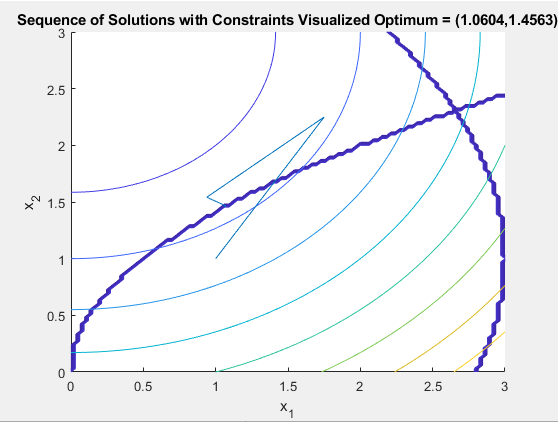


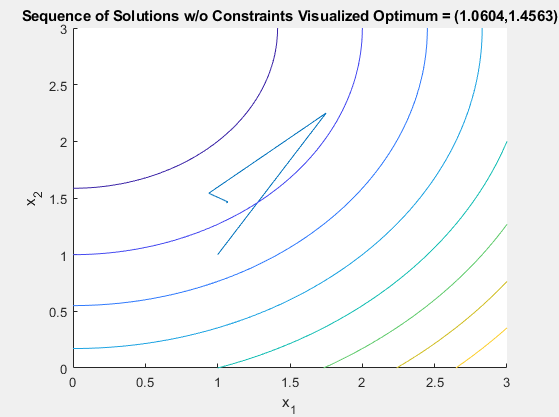

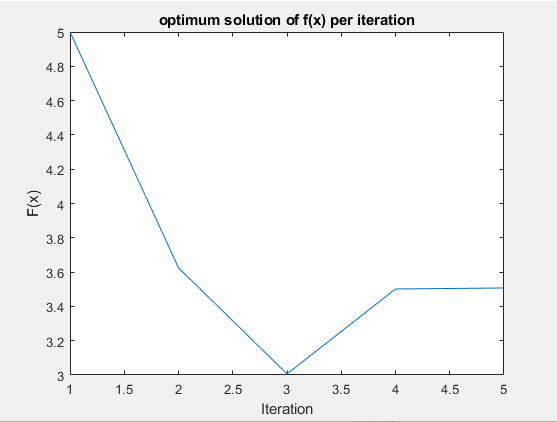